In [1]:
import tensorflow as tf
import keras
import config
import os
import argparse
import logging

from src import model
from src import preprocessing
from src import dataGenerator
from src import util
from src import model
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:


#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
#_config = tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Checking for param json folder and creating logging file
if not os.path.exists(config.pathParam):
    paramDict = config.modelParam
    util.save_json(paramDict, config.pathParam)

# Checking for logging folder and creating logging file
util.check_dir(config.pathLog)
util.set_logger(os.path.join(config.pathLog, 'train.log'))




In [3]:

###############################################################################
# Loading Parameters
assert os.path.isfile(
config.pathParam), "No json configuration for model found at {}".format(config.pathParam)

logging.info('Loading Parameters')
params = util.Params(config.pathParam)


Loading Parameters


In [4]:

# Training Data to Data Generator format
logging.info('Training Data to Data Generator format')
getTrainingData = dataGenerator.getData(pathImage=config.pathTraining)
trainingIndexes, trainingImageMap, trainingLabelMap = getTrainingData.getList()

logging.info('Creating Training Data Generator')
trainingGenerator = dataGenerator.DataGenerator(
list_IDs=trainingIndexes, imageMap=trainingImageMap, labelMap=trainingLabelMap, params=params, prediction=False, shuffle=True)


Training Data to Data Generator format
Creating Training Data Generator


In [5]:

# Validation Data to Data Generator format
getValidationData = dataGenerator.getData(pathImage=config.pathTesting)
validationIndexes, validationImageMap, validationLabelMap = getValidationData.getList()

logging.info('Validation data to Data Generator format')
validationGenerator = dataGenerator.DataGenerator(
list_IDs=validationIndexes, imageMap=validationImageMap, labelMap=validationLabelMap, params=params, prediction=False, shuffle=True)


Validation data to Data Generator format


In [6]:
import importlib
importlib.reload(model)

<module 'src.model' from '/home/arnav/Documents/EyeQual_Final/src/model.py'>

In [7]:
for i, tg in enumerate(trainingGenerator):
    a, b = tg
    print('mean arr: {}, mean label: {}, counter: {}, a shape: {}, b shape: {}'.format(np.mean(a), np.mean(b), i, a.shape, b.shape))

mean arr: 0.33853630427441583, mean label: 0.5, counter: 0, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.2310221615959618, mean label: 0.625, counter: 1, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.28713244082880957, mean label: 0.75, counter: 2, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.3329350833020179, mean label: 0.625, counter: 3, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.26562643799127317, mean label: 0.75, counter: 4, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.3216423340093081, mean label: 0.75, counter: 5, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.3160226223515528, mean label: 0.375, counter: 6, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.34251622281043353, mean label: 0.375, counter: 7, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.21461135826858835, mean label: 0.875, counter: 8, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.23424284691904132, mean label: 0.5, counter: 9, a sh

In [8]:

# Initilizing Model
logging.info('Initializing Model')

# Model Training
path_save_callback = os.path.join(
config.pathOutputModel, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5')
savingModel = keras.callbacks.ModelCheckpoint(path_save_callback,
                                           monitor='val_loss',
                                           verbose=0,
                                           save_best_only=False,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=5)

csvLogger = keras.callbacks.CSVLogger(
    os.path.join(config.pathLog, 'trainingLog.csv'),  append=True)

retinaModel, retinaHeatMap = model.retinaModel(params)

logging.info('Compiling Model')
retinaModel.compile(optimizer=keras.optimizers.Adam(lr=params.learningRate),
                   loss='binary_crossentropy', metrics=['accuracy'])



Initializing Model
Input shape: (None, 512, 512, 3)
After Conv 0 shape: (None, 510, 510, 64)
After Max Pool 0 shape: (None, 255, 255, 64) 
After Conv 1 shape: (None, 253, 253, 128)
After Max Pool 1 shape: (None, 126, 126, 128) 
After Conv 2 shape: (None, 124, 124, 256)
After Max Pool 2 shape: (None, 62, 62, 256) 
After Conv 3 shape: (None, 60, 60, 512)
After Max Pool 3 shape: (None, 30, 30, 512) 
################### Heat Map Model #################
################### Label Prediction Model #################
Compiling Model


Patches Y: (None, 1)


In [9]:
retinaModel.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 510, 510, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 255, 255, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 253, 253, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 256)     295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 256)       0   

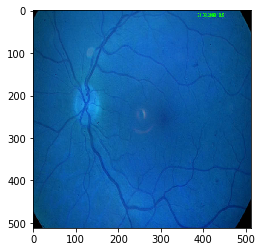

In [10]:
plt.imshow(np.array(trainingGenerator[11][0][0]*255, dtype=int))

In [11]:
history = retinaModel.fit_generator(generator=trainingGenerator,
                                   validation_data=validationGenerator,
                                   epochs=100,
                                   use_multiprocessing=True,
                                   workers=10,
                                   callbacks=[savingModel, csvLogger],
                                   verbose=1)

Epoch 1/100
77/77 [==============================] - 171s 2s/step - loss: 0.7087 - accuracy: 0.6851 - val_loss: 0.6017 - val_accuracy: 0.6645
Epoch 2/100
77/77 [==============================] - 168s 2s/step - loss: 0.6242 - accuracy: 0.7451 - val_loss: 0.5248 - val_accuracy: 0.6842
Epoch 3/100
77/77 [==============================] - 169s 2s/step - loss: 0.6133 - accuracy: 0.7565 - val_loss: 0.7001 - val_accuracy: 0.6974
Epoch 4/100
77/77 [==============================] - 169s 2s/step - loss: 0.6028 - accuracy: 0.7597 - val_loss: 0.5018 - val_accuracy: 0.6645
Epoch 5/100
77/77 [==============================] - 168s 2s/step - loss: 0.5906 - accuracy: 0.7825 - val_loss: 0.5276 - val_accuracy: 0.7105
Epoch 6/100
77/77 [==============================] - 168s 2s/step - loss: 0.5816 - accuracy: 0.8019 - val_loss: 0.5806 - val_accuracy: 0.6908
Epoch 7/100
77/77 [==============================] - 169s 2s/step - loss: 0.5812 - accuracy: 0.7808 - val_loss: 0.5789 - val_accuracy: 0.6645
Epoch 

77/77 [==============================] - 168s 2s/step - loss: 0.5688 - accuracy: 0.7857 - val_loss: 0.6864 - val_accuracy: 0.7566
Epoch 59/100
77/77 [==============================] - 168s 2s/step - loss: 0.5668 - accuracy: 0.7744 - val_loss: 0.6708 - val_accuracy: 0.7632
Epoch 60/100
77/77 [==============================] - 168s 2s/step - loss: 0.5673 - accuracy: 0.8166 - val_loss: 0.5543 - val_accuracy: 0.7368
Epoch 61/100
77/77 [==============================] - 170s 2s/step - loss: 0.5637 - accuracy: 0.7695 - val_loss: 0.5456 - val_accuracy: 0.7500
Epoch 62/100
77/77 [==============================] - 171s 2s/step - loss: 0.5590 - accuracy: 0.7841 - val_loss: 0.5656 - val_accuracy: 0.7368
Epoch 63/100
77/77 [==============================] - 169s 2s/step - loss: 0.5552 - accuracy: 0.7922 - val_loss: 0.7434 - val_accuracy: 0.7829
Epoch 64/100
77/77 [==============================] - 170s 2s/step - loss: 0.5569 - accuracy: 0.7906 - val_loss: 0.7814 - val_accuracy: 0.7697
Epoch 65/100

In [12]:
logging.info('Saving Last model...')
pathTrainedRetinaModel = os.path.join(config.pathOutputModel, 'retinaModel.h5')
pathTrainedHeatMapModel = os.path.join(config.pathOutputModel, 'heatMapModel.h5')


retinaModel.save(pathTrainedRetinaModel)
retinaHeatMap.save(pathTrainedHeatMapModel)
logging.info('Retina Model: {}, HeatMap Model: {}'.format(pathTrainedRetinaModel, pathTrainedHeatMapModel))


Saving Last model...
Retina Model: experiments/1/model/retinaModel.h5, HeatMap Model: experiments/1/model/heatMapModel.h5


In [13]:
import cv2

In [14]:
retinaModel.evaluate_generator(validationGenerator, verbose=1)

19/19 [==============================] - 11s 553ms/step


[0.6089262962341309, 0.7236841917037964]

In [15]:
pred = []
img = []
lb = []
for tdg in validationGenerator:
    img1, lb1 = tdg[0], tdg[1]
    pred.append(retinaHeatMap.predict(img1))
    img.append(img1)
    lb.append(lb1)

In [19]:
count = 0
for i in range(len(pred)):
    for j in range(len(pred[i])):
        temp_label = lb[i][j]
        temp_img = img[i][j]
        temp_heat = cv2.resize(pred[i][j][:, :, 0], (512, 512))
        temp_heat = cv2.cvtColor(temp_heat, cv2.COLOR_GRAY2RGB)
        cv2.imwrite(os.path.join(config.pathOutputHeatMap, str(count) + '_heat_p{}.jpg'), temp_heat*255)
        cv2.imwrite(os.path.join(config.pathOutputHeatMap, str(count) + '_img_p{}.jpg'), temp_img * 255)
        count +=1

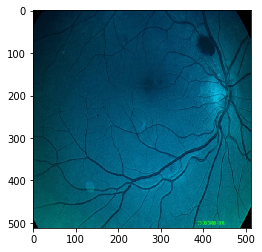

In [17]:
plt.imshow(temp_img)